# RG374 FACS analysis IFNAR fl LysMcre CpG

In [1]:
options(warn=-1)

In [2]:
library_load <- suppressMessages(
    
    suppressWarnings(
        
        list(
                         
            # Data 
            library(tidyverse), 
            library(data.table), 
            library(reactable), 

            # Plotting 
            library(ComplexHeatmap), 
            library(patchwork), 
            library(cowplot), 
            library(ggrepel)

        )
    )
)

In [3]:
random_seed <- 42
set.seed(random_seed)

In [4]:
# Set working directory to project root
setwd("/research/peer/fdeckert/FD20200109SPLENO")

In [5]:
# Plotting Theme
source("plotting_global.R")
ggplot2::theme_set(theme_global_set(size_select=1)) # From project global source()

# Functions 

In [6]:
scale_label <- function(x, y) {
    
    max_y <- max(x[[y]])
    float_y <- attr(regexpr("(?<=\\.)0+", max_y, perl = TRUE), "match.length")
    
    if(max_y>=1) {
    
        x <- x
        ylab="10^6~x~cells/spleen"
        
        return(list(mat=x, ylab=ylab))

    } else if (float_y==-1) {
        
        x[[y]] <- x[[y]]*10
        ylab <- paste0("10^5~x~cells/spleen")

        return(list(mat=x, ylab=ylab)) 
    
    } else {

        exp_scale <- 1+float_y

        x[[y]] <- x[[y]]*10^exp_scale
        ylab <- paste0("10^", 6-exp_scale, "~x~cells/spleen")

        return(list(mat=x, ylab=ylab))

    }
        
}

In [ ]:
    geom_bar(position="fill", width=0.8, color="black", size=0.1) + 
    scale_fill_manual(values=color$celltype_low) + 
    ggtitle("") + xlab("") + ylab("Celltype [ratio]") + 
    facet_wrap(~celltype_high, scales="free", ncol=1) + 
    scale_x_discrete(labels=c("Rep1", "Rep2", "Rep1", "Rep2")) + 
    theme(axis.text.x=element_text(angle=90, vjust=0.5, hjust=1)) + 
    guides(fill=guide_legend(ncol=1, override.aes=list(alpha=1, size=1.5), keywidth=0.25, keyheight=0.25, default.unit="cm"))

In [93]:
bar_plot <- function(mat, x, y, xlab="", ylab="", ggtitle="", scale_y=FALSE, parse_y=FALSE) {
    
    if(scale_y) {
        
        res <- scale_label(mat, deparse(substitute(y)))
        mat <- res[[1]]
        ylab <- res[[2]]

    }
    
    p <- ggplot(mat, aes(x={{x}}, y={{y}}, color=genotype, fill=genotype)) + 
    
        geom_bar(stat="summary", width=0.8, color="black", size=0.1) + 
        geom_jitter(shape=21, stroke=0.1, size=1.0, show.legend=FALSE, color="black") + 
        xlab(xlab) + ylab(ylab) + ggtitle(ggtitle) + 
        scale_color_manual(values=color$genotype) + 
        scale_fill_manual(values=color$genotype) + 
        theme(axis.text.x=element_text(angle=90, vjust=0.5, hjust=1)) + 
        guides(fill=guide_legend(ncol=1, override.aes=list(alpha=1, size=1.5), keywidth=0.25, keyheight=0.25, default.unit="cm"))
    
    if(parse_y) {
        
        p <- p + ylab(parse(text=ylab))
        
    }
    
    return(p)
    
}

# Import data 

In [8]:
sheet_names <- openxlsx::getSheetNames("data/RG374_ifnar_fl_lysmcre_cpg/facs/spleen//RG374_facs_spleen_data.xlsx")

In [9]:
data <- lapply(sheet_names, function(x) openxlsx::read.xlsx("data/RG374_ifnar_fl_lysmcre_cpg/facs/spleen//RG374_facs_spleen_data.xlsx", sheet=x))
names(data) <- sheet_names

# Set color

In [10]:
color$genotype <- c("+/+"="#FFFFFF", "cre/+"="#998989")

## Spleen weight 

In [11]:
mat <- data[["spleen_overview"]] %>% 
    dplyr::select(-Mutation.1, -Grad.1, -Mutation.2, -sample, -viable_cells) %>% 
    dplyr::rename(genotype=Grad.2, time_point=well) %>%
    dplyr::mutate(genotype=factor(genotype, levels=c("+/+", "cre/+"))) %>% 
    dplyr::mutate(time_point=ifelse(time_point=="baseline", "D0", ifelse(time_point=="day3", "D3", "D6"))) %>% 
    dplyr::mutate(time_point=factor(time_point, levels=c("D0", "D3", "D6")))

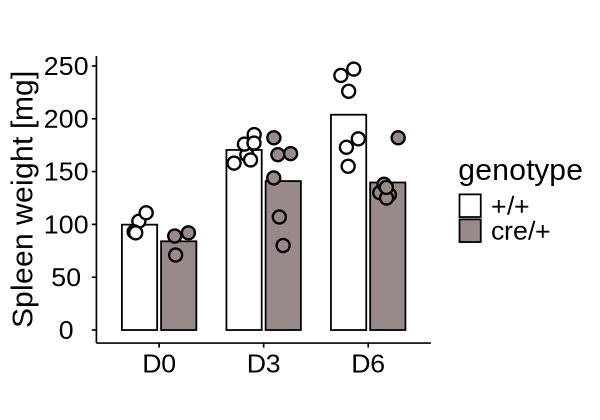

In [12]:
options(repr.plot.width=5, repr.plot.height=3.5)

bar_plot(mat, time_point, spleen_weight_mg, ylab="Spleen weight [mg]")

## Viable cells 

In [13]:
mat <- data[["spleen_overview"]] %>% 
    dplyr::select(-Mutation.1, -Grad.1, -Mutation.2, -sample, -spleen_weight_mg) %>% 
    dplyr::rename(genotype=Grad.2, time_point=well) %>% 
    dplyr::mutate(genotype=factor(genotype, levels=c("+/+", "cre/+"))) %>% 
    dplyr::mutate(time_point=ifelse(time_point=="baseline", "D0", ifelse(time_point=="day3", "D3", "D6"))) %>% 
    dplyr::mutate(time_point=factor(time_point, levels=c("D0", "D3", "D6"))) %>%
    dplyr::mutate(viable_cells=viable_cells/10^4)

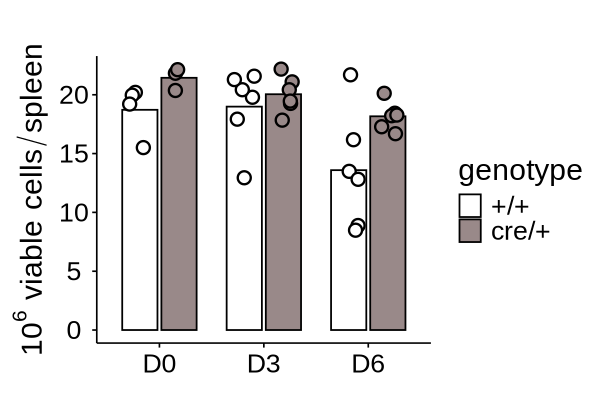

In [14]:
options(repr.plot.width=5, repr.plot.height=3.5)

bar_plot(mat, time_point, viable_cells, ylab="10^6~viable~cells/spleen", parse_y=TRUE)

## CD44 SSC gating 

In [15]:
mat <- data[["cd44_ssc_gating"]] %>% 
    dplyr::select(-Mutation.1, -Grad.1, -Mutation.2, -sample) %>% 
    dplyr::rename(genotype=Grad.2, time_point=well) %>% 
    dplyr::mutate(genotype=factor(genotype, levels=c("+/+", "cre/+"))) %>% 
    dplyr::mutate(time_point=ifelse(time_point=="baseline", "D0", ifelse(time_point=="day3", "D3", "D6"))) %>% 
    dplyr::mutate(time_point=factor(time_point, levels=c("D0", "D3", "D6"))) %>%
    reshape2::melt(., id.vars=c("genotype", "time_point"), variable="cell_type", value.name=c("ratio"))  

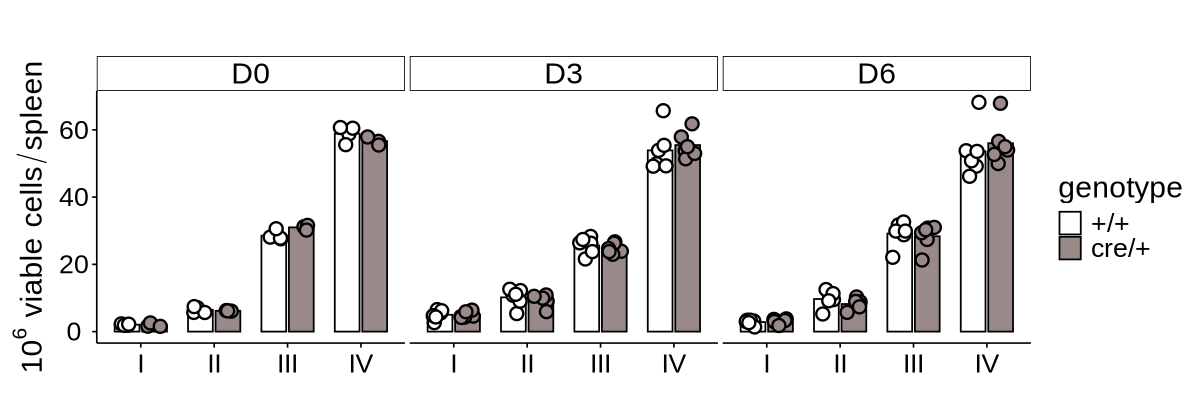

In [16]:
options(repr.plot.width=10, repr.plot.height=3.5)

bar_plot(mat, cell_type, ratio, ylab="10^6~viable~cells/spleen", parse_y=TRUE) + facet_grid(~time_point)

# Relative cell numbers 

In [94]:
mat <- data[["relative"]] %>% 
    dplyr::select(-Mutation.1, -Grad.1, -Mutation.2, -sample) %>% 
    dplyr::rename(genotype=Grad.2, time_point=well) %>% 
    dplyr::mutate(genotype=factor(genotype, levels=c("+/+", "cre/+"))) %>% 
    dplyr::mutate(time_point=ifelse(time_point=="baseline", "D0", ifelse(time_point=="day3", "D3", "D6"))) %>% 
    dplyr::mutate(time_point=factor(time_point, levels=c("D0", "D3", "D6"))) %>%
    dplyr::mutate(genotype=paste(time_point, genotype)) %>% 
    dplyr::mutate(genotype=factor(genotype, levels=c("D0 +/+", "D0 cre/+", "D3 +/+", "D3 cre/+", "D6 +/+", "D6 cre/+"))) %>% 
    reshape2::melt(., id.vars=c("genotype", "time_point"), variable="cell_type", value.name=c("ratio"))  

In [95]:
bar_plot_1 <- lapply(split(mat, f=mat$cell_type), function(x) bar_plot(x, genotype, ratio, ylab="Ratio [%]", ggtitle=x$cell_type[1]) + theme_global_set(4))

No summary function supplied, defaulting to `mean_se()`
No summary function supplied, defaulting to `mean_se()`
No summary function supplied, defaulting to `mean_se()`
No summary function supplied, defaulting to `mean_se()`
No summary function supplied, defaulting to `mean_se()`
No summary function supplied, defaulting to `mean_se()`
No summary function supplied, defaulting to `mean_se()`
No summary function supplied, defaulting to `mean_se()`
No summary function supplied, defaulting to `mean_se()`
No summary function supplied, defaulting to `mean_se()`
No summary function supplied, defaulting to `mean_se()`
No summary function supplied, defaulting to `mean_se()`
No summary function supplied, defaulting to `mean_se()`
No summary function supplied, defaulting to `mean_se()`
No summary function supplied, defaulting to `mean_se()`
No summary function supplied, defaulting to `mean_se()`
No summary function supplied, defaulting to `mean_se()`
No summary function supplied, defaulting to `mea

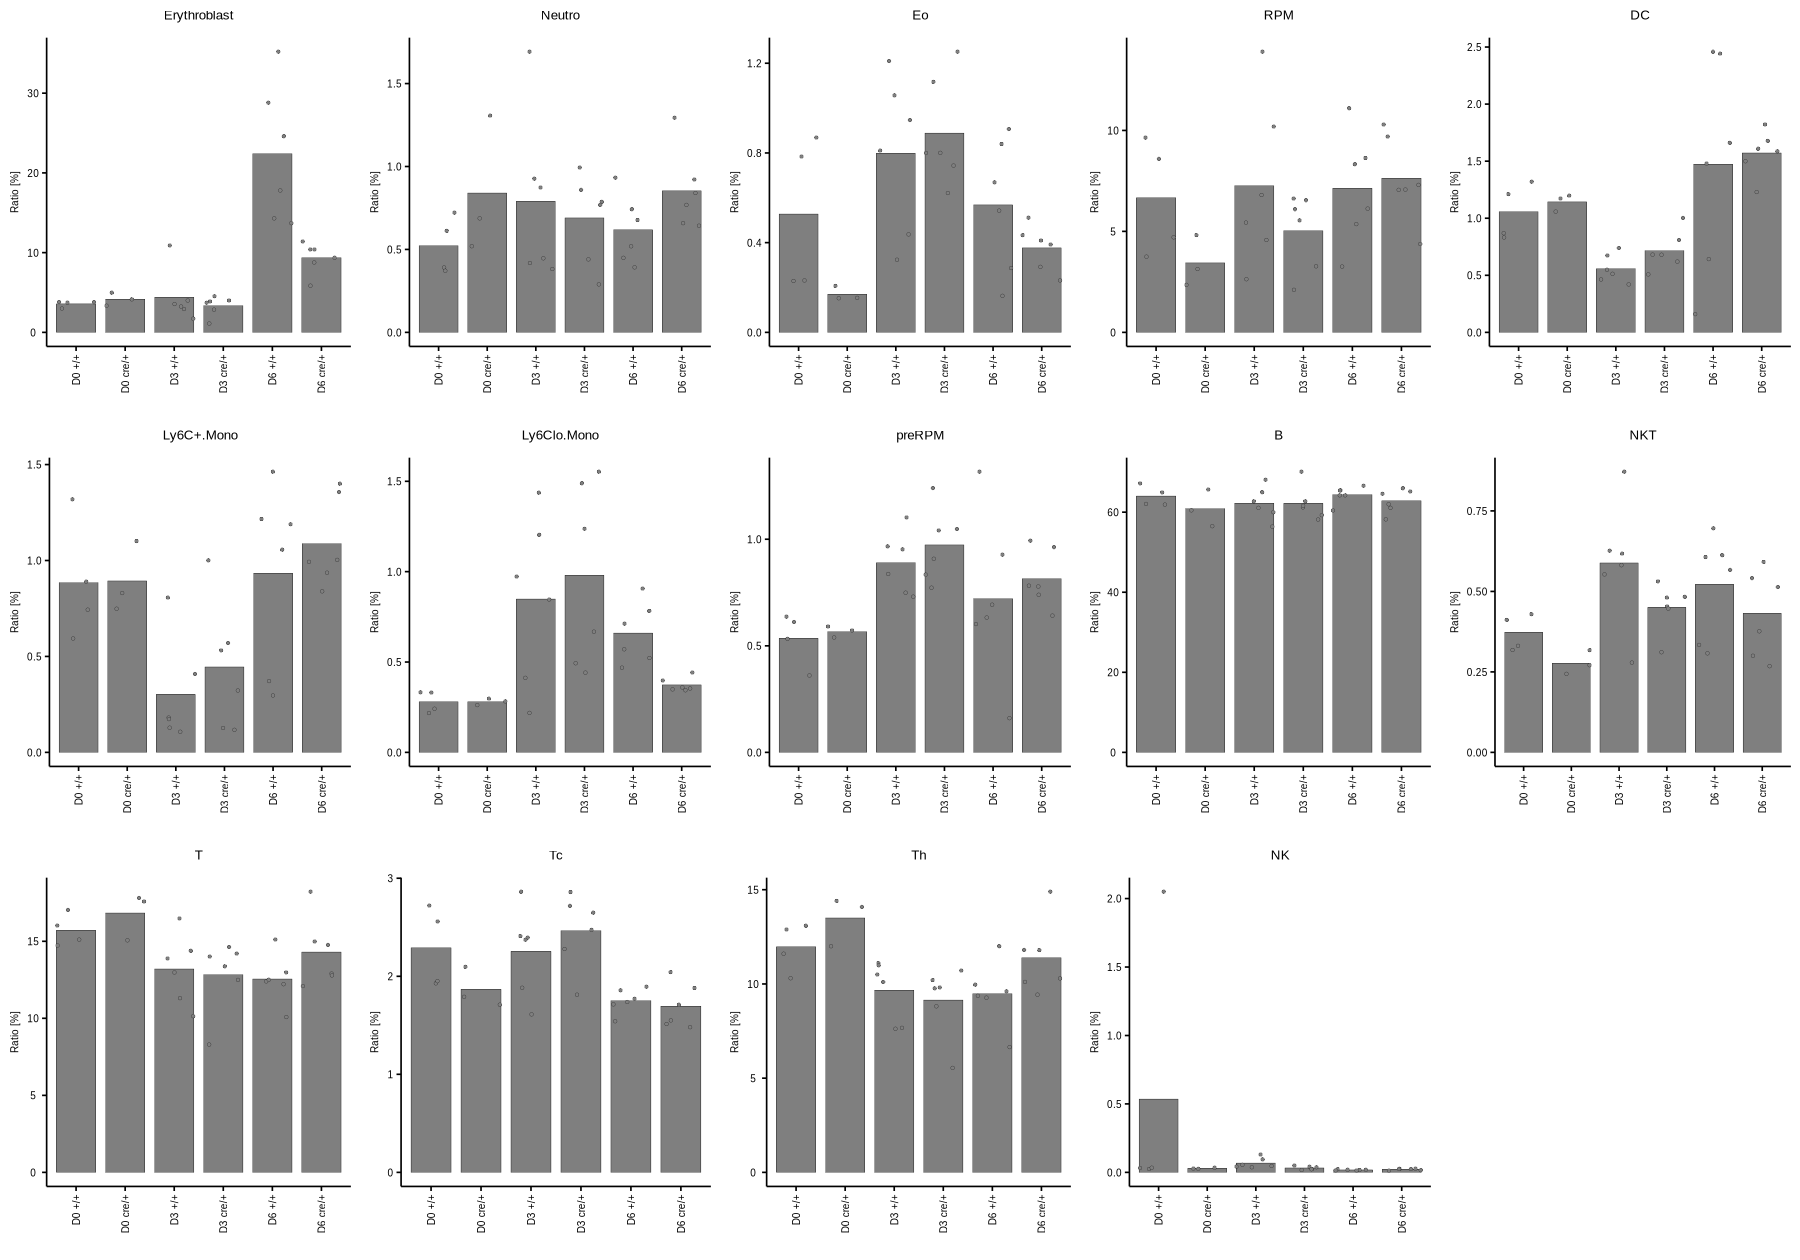

In [96]:
options(repr.plot.width=5*3, repr.plot.height=3*3.5)

ggpubr::ggarrange(plotlist=bar_plot_1, ncol=5, nrow=3, common.legend=TRUE, legend="bottom")

In [98]:
pdf("result/figures/dev/bp_facs.pdf", width=2, height=4)

gridExtra::grid.arrange(

    bar_plot_1[[1]] %>% egg::set_panel_size(., width=unit(6*0.3, "cm"), height=unit(2.0, "cm")), ncol=1
        
)

dev.off()

No summary function supplied, defaulting to `mean_se()`


pdf 
  2

## Absolut numbers 

In [20]:
mat <- data[["absolut"]] %>% 
    dplyr::select(-Mutation.1, -Grad.1, -Mutation.2, -sample) %>% 
    dplyr::rename(genotype=Grad.2, time_point=well) %>% 
    dplyr::mutate(genotype=factor(genotype, levels=c("+/+", "cre/+"))) %>% 
    dplyr::mutate(time_point=ifelse(time_point=="baseline", "D0", ifelse(time_point=="day3", "D3", "D6"))) %>% 
    dplyr::mutate(time_point=factor(time_point, levels=c("D0", "D3", "D6"))) %>%
    reshape2::melt(., id.vars=c("genotype", "time_point"), variable="cell_type", value.name=c("count"))

In [21]:
bar_plot_1 <- lapply(split(mat, f=mat$cell_type), function(x) bar_plot(x, time_point, count, scale_y=TRUE, parse_y=TRUE, ggtitle=x$cell_type[1]))

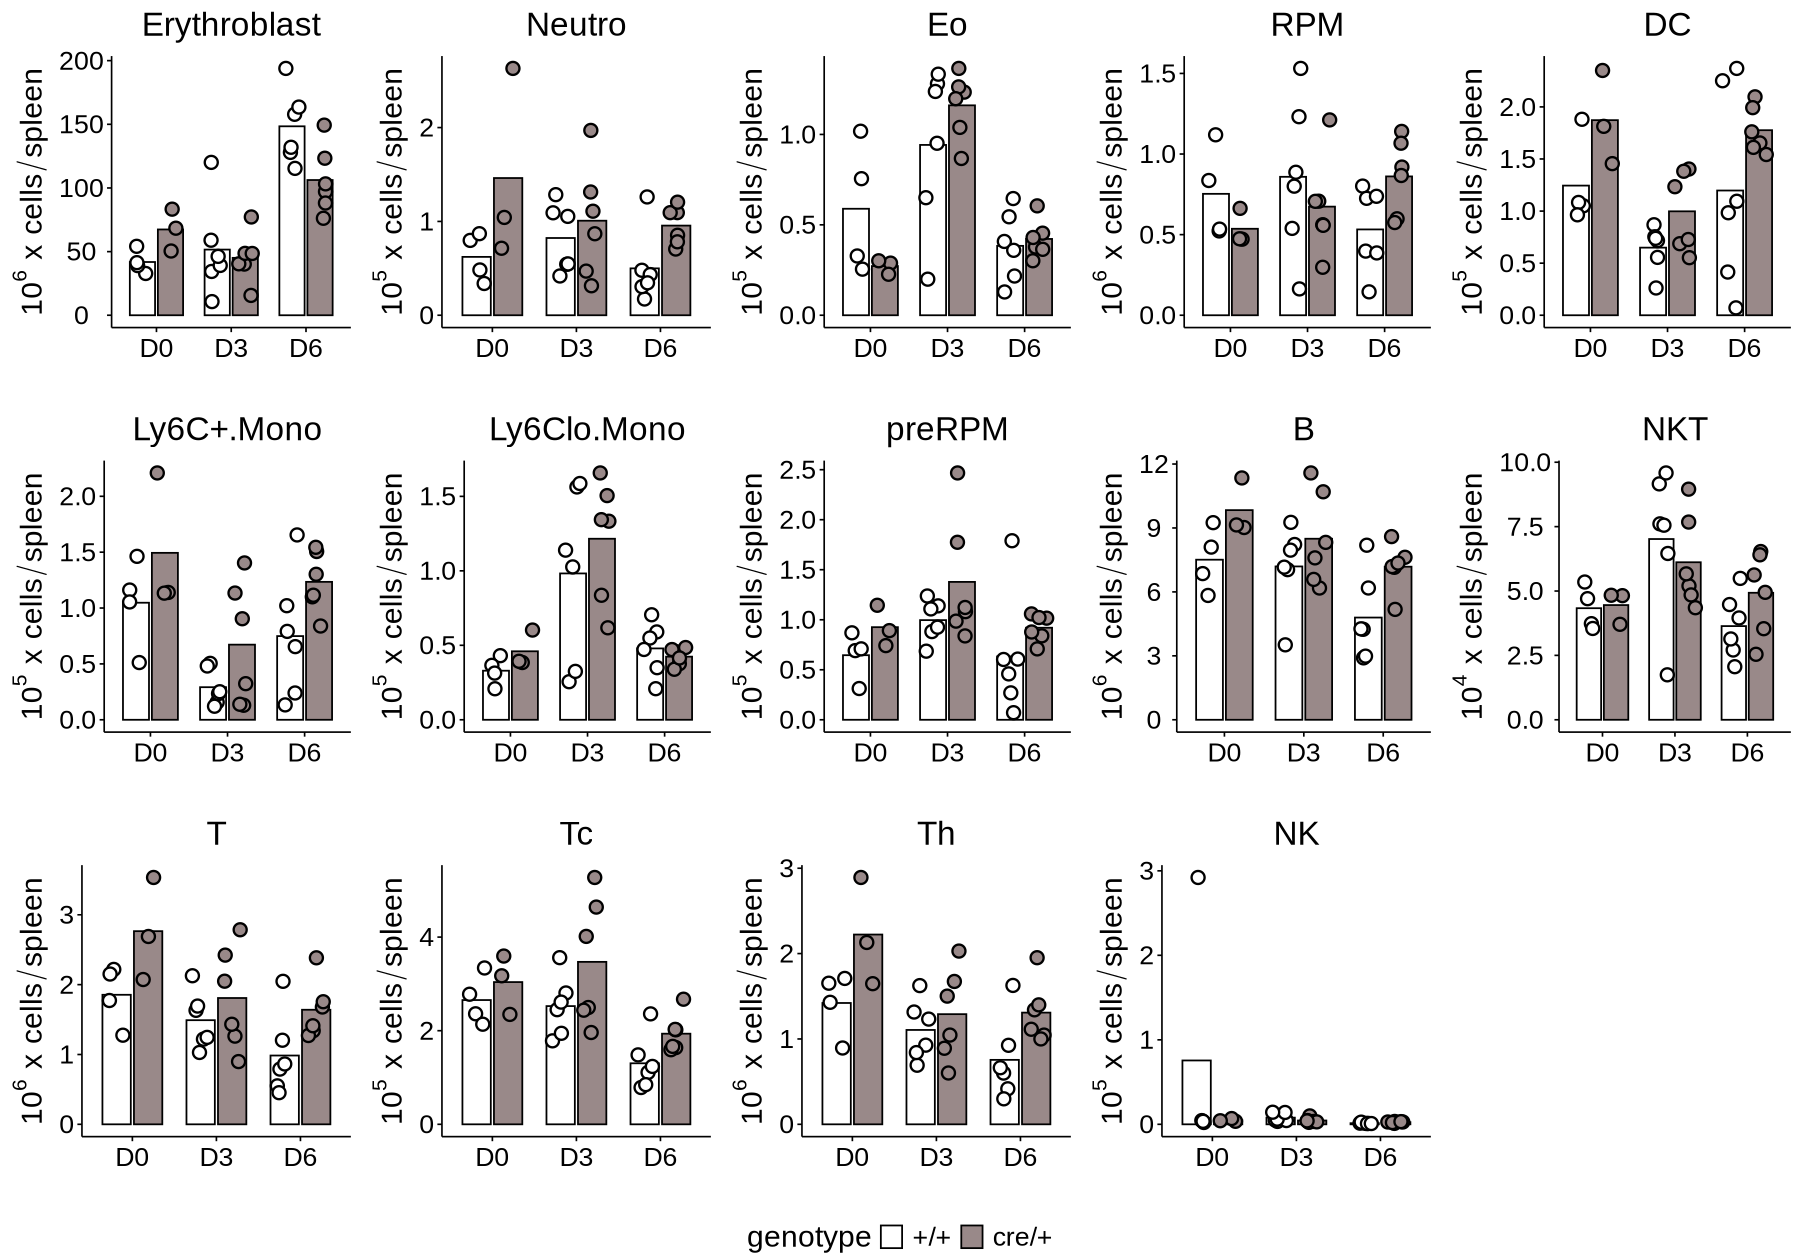

In [22]:
options(repr.plot.width=5*3, repr.plot.height=3*3.5)

ggpubr::ggarrange(plotlist=bar_plot_1, ncol=5, nrow=3, common.legend=TRUE, legend="bottom")